<h2 style="text-align: center;"><b>Перцептрон Розенблатта<br><br></b></h2>

<h2 style="text-align: center;"><b>Введение</b></h2>

Почти любой алгоритм машинного обучения, решающий задачу *классификации* или *регрессии*, работает так:

1. (*стадия инициализации*) Задаются его **гиперпараметры**, то есть те величины, которые не "выучиваются" алгоритмом в процессе обучения самостоятельно 
2. (*стадия обучения*) Алгоритм запускается на данных, **обучаясь** на них и меняя свои **параметры** (не путать с *гипер*параметрами) каким-то определённым образом (например, с помощью *метода градиентного спуска* или *метода коррекции ошибки*), исходя из функции потерь (её называют *loss function*). Функция потерь, по сути, говорит, где и как ошибается модель
3.  (*стадия предсказания*) Модель готова, и теперь с помощью неё можно делать **предсказания** на новых объектах

In [1]:
from matplotlib import pyplot as plt         #импортируем библиотеки
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

<h2 style="text-align: center;"><b>Класс Perceptron</b></h2>

В даном разделе будет решаться задача **бинарной классификации** с помощью перцептрона:  
- *Входные данные*: матрица $X$ размера $(n, m)$ и столбец $y$ из нулей и единиц размера $(n, 1)$. Строкам матрицы соответствуют объекты, столбцам - признаки (то есть строка $i$ есть набор признаков (*признаковое описание*) объекта $X_i$).
- *Выходные данные*: столбец $\hat{y}$ из нулей и единиц размера $(n, 1)$ - предсказания алгоритма.

Чтобы понять, как мы будем обновлять параметры модели (веса), нужно знать, какую функцию потерь мы оптимизируем (находим минимум). В данном случае мы решаем задачу бинарной классификации (2 класса: 1 или 0), возьмём в качестве функции потерь среднеквадратичную ошибку:  

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (f(w \cdot X_i + b) - y_i)^2$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $f()$ - пороговая функция:  

$$
f(w \cdot X_i + b) =
\begin{cases}
1, &\text{если } w \cdot X_i + b > 0 \\
0, &\text{если } w \cdot X_i + b \le 0
\end{cases}
$$  

**Примечание:** На самом деле можно считать, что $b$ - свободный член - является частью вектора весов: $w_0$, приписав к $X$ слева единичный столбец, тогда в скалярном произведении с каждым объектом $b$ будет именно как свободный член. При реализации класса `Perceptron()` мы будем обновлять $b$ отдельно от $w$.

Реализуем функцию потерь:

In [2]:
def Loss(y_pred, y):
    '''
    Считаем среднеквадратичную ошибку
    '''
    y_pred = y_pred.reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Поскольку у *пороговой функции* не существует производной в нуле, то мы не можем использовать градиентный спуск, ведь:  

$$ \frac{\partial Loss}{\partial w} = \frac{1}{n} X^T\left(f(w \cdot X) - y\right)f'(w \cdot X)$$  

где $f^{'}(w \cdot X)$ -- в точке 0 посчитать не получится. Но хочется как-то обновлять веса, иначе обучения не случиться.

Поэтому предлагается обновлять так:   

$$w^{j+1} = w^{j} - \alpha\Delta{w^{j}}$$ 
$$b^{j+1} = b^{j} - \alpha\Delta{b^{j}}$$ 

где:  

$$\Delta{w} = \frac{1}{n}X^T(\hat{y} - y) = \frac{1}{n}X^T(f(X \cdot w^j + b^j) - y)$$  
$$\Delta{b} = \frac{1}{n}X^T(\hat{y} - y) = \frac{1}{n}1^T(f(X \cdot w^j + b^j) - y)$$  

где $w \cdot X$ - матричное произведение столбца весов $w$ на матрицу объектов-признаков $X$, $1^T$ -- вектор-строка из единиц, а индекс $j$ -- номер итерации градиентного спуска.

Вооружившись всеми формулами, напишем свой класс **`Perceptron()`**. 

*Примечание*: В коде ниже `y_pred` -- это $\hat{y}$ из формул выше

In [3]:
class Perceptron:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # Пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b
        
    def activate(self, x):
        return np.array(x > 0, dtype=np.int64)
        
    def forward_pass(self, X):
        """
        Эта функция рассчитывает ответ перцептрона при предъявлении набора объектов
        :param: X -- матрица объектов размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами перцептрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов перцептрона в соответствии с этим объектом
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        self.w = self.w - learning_rate * (X.T @ (y_pred - y) / n)
        self.b = self.b - learning_rate * np.mean(y_pred - y)
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение
        losses = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            losses.append(Loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)

        return losses

Класс готов. Посмотрим, правильно ли ведёт себя перцептрон. Далее идут несколько ячеек с тестовым кодом, вам нужно просто запустить их и проверить, чтобы результаты запуска совпадали с соответствующими числами из таблиц:

**Проверка forward_pass():**

In [4]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 2., -1.], [3., 4., -3.2]])

perceptron = Perceptron(w, b)
y_pred = perceptron.forward_pass(X.T)
print ("y_pred = " + str(y_pred))

y_pred = [[1]
 [1]
 [0]]


**Проверка backward_pass():**

In [5]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [6]:
perceptron.backward_pass(X.T, y, y_pred)

print ("w = " + str(perceptron.w))
print ("b = " + str(perceptron.b))

w = [[0.995]
 [1.988]]
b = 2.0


Посмотрим, как меняется функция потерь в течение процесса обучения на реальных данных - датасет "Яблоки и Груши":

In [7]:
data = pd.read_csv("apples_pears.csv")

In [8]:
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


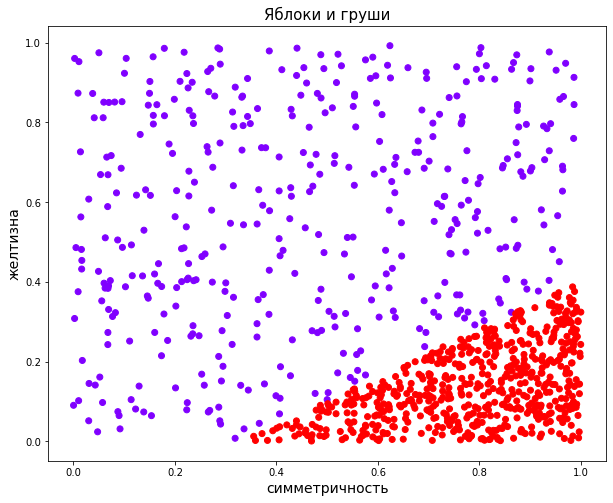

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

**Вопрос:** Какой класс соответствует яблокам (какого они цвета на графике)?

Обозначим, что здесь признаки, а что - классы:

In [10]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

**Вывод функции потерь**  
Функция потерь должна убывать и в итоге стать близкой к 0

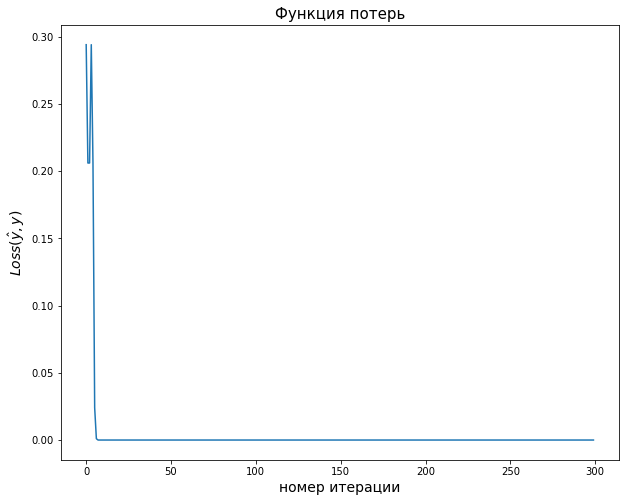

Wall time: 312 ms


In [11]:
%%time
perceptron = Perceptron()
losses = perceptron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как перцептрон классифицировал объекты из выборки:

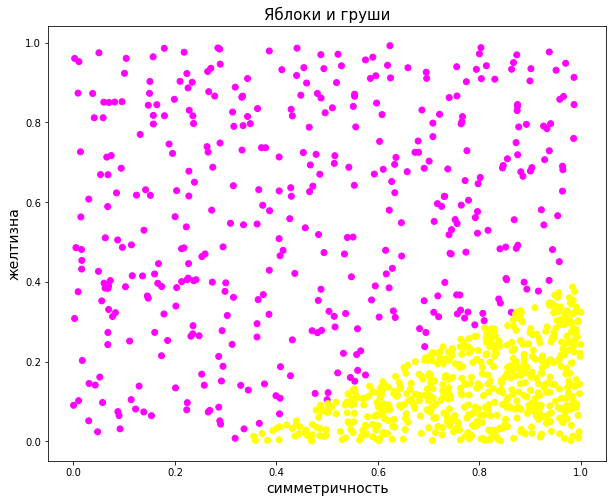

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=perceptron.forward_pass(X).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Справился идеально. Однако просьба обратить внимание, что это очень простая, *линейно разделимая*, выборка.

Также можно импортировать персептрон из библиотеки sklearn и обучать его.

In [13]:
from sklearn.linear_model import Perceptron as sklPerceptron

Вы можете самостоятельно провести его обучение на тех же данных и сравнить полученные результаты при помощи той или иной метрики, например при прмощи accuracy_score

Необходимо отметить, что перцептрон или один нейрон сам по себе не используется в приложениях. В приложениях используются сети, состоящие из большого количества нейронов или еще более сложных структур, о которых 